In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from astropy.time import Time
import numpy as np
import glob
import pandas as pd
import re
from datetime import datetime
import dask.dataframe as dd
import torch

In [5]:
from torch.utils import data

In [6]:
from matplotlib import cm

## Helper functions 

Define some important helper functions to be used later

In [7]:
import sys
sys.path.append('../')
from dataloader import SuperMAGIAGADataset,OMNIDataset,ShpericalHarmonicsDatasetBucketized
from utils.data_utils import get_omni_data,get_iaga_data_as_list
from utils.splitter import generate_indices
from metricgen import EventMetrics,Generate_metrics
from Forecaster import Forecaster,Generate_complete_weimer_forecast,Generate_weimer_forecast
from models.geoeffectivenet import *
import pickle
torch.set_default_dtype(torch.float64)  # this is important else it will overflow

In [8]:
import matplotlib.colors

class SqueezedNorm(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, mid=0, s1=2, s2=2, clip=False):
        self.vmin = vmin # minimum value
        self.mid  = mid  # middle value
        self.vmax = vmax # maximum value
        self.s1=s1; self.s2=s2
        f = lambda x, zero,vmax,s: np.abs((x-zero)/(vmax-zero))**(1./s)*0.5
        self.g = lambda x, zero,vmin,vmax, s1,s2: f(x,zero,vmax,s1)*(x>=zero) - \
                                             f(x,zero,vmin,s2)*(x<zero)+0.5
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        r = self.g(value, self.mid,self.vmin,self.vmax, self.s1,self.s2)
        return np.ma.masked_array(r)

# Load hyperparameters

In [9]:
future_length = 1 #WAS DEFAULT IN THE CODE
past_omni_length = 120
nmax = 20
targets = ["dbe_nez", "dbn_nez"]
lag = 30
learning_rate = 5e-3
batch_size = 8500
omni_resolution = 1
dropout_prob = 0.7
l2reg = 5e-5
n_hidden = 8
loss = 'MAE'
basepath = f"../Best/Reg_Faster_FULL_NeuralRNNWiemer_{loss}_{past_omni_length}_{nmax}_{n_hidden}_{learning_rate*1e6}_{l2reg*1e6}/"

# load scaler to unstandardize data
scalers = pickle.load(open(f"{basepath}scalers.p", "rb"))
_mean, _std = scalers["supermag"]

dbe_mean, dbn_mean = _mean
dbe_std, dbn_std = _std

# Load data

In [10]:
yearlist = list(np.arange(2011,2018).astype(int))
supermag_data = SuperMAGIAGADataset(*get_iaga_data_as_list(base="../full_data_panos/iaga/",year=yearlist))
yearlist = list(np.arange(2011,2018).astype(str))
omni_data = OMNIDataset(get_omni_data("../data_local/omni/sw_data.h5", year=yearlist))

yearlist = list(np.arange(2011,2018).astype(int))
train_idx,test_idx,val_idx,wiemer_idx = generate_indices(base="../full_data_panos/iaga/",year=yearlist,
                                                    LENGTH=past_omni_length,LAG=lag,
                                                    omni_path="../data_local/omni/sw_data.h5",
                                                    weimer_path="../data_local/weimer/")
train_idx = np.asarray(train_idx)
val_idx = np.asarray(val_idx)
test_idx = np.asarray(test_idx)
wiemer_idx = np.asarray(wiemer_idx)

train_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,train_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=None,training_batch=True,nmax=nmax)
print("Train dataloader defined....")
test_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,test_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=train_ds.scaler,training_batch=False,nmax=nmax)
print("Test dataloader defined....")
wiemer_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,wiemer_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=train_ds.scaler,training_batch=False,nmax=nmax)
print("Weimer dataloader defined....")

loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 2221.08it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.74s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.62s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.17s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:36<00:00,  3.04s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.83s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.86s/it]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.05s/it]


loading from path ../full_data_panos/iaga/ /
loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 375.11it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 648.71it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 609.76it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 610.37it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 67.25it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 132.49it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 609.93it/s]


loading supermag iaga data...


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 606.90it/s]


testing 2011
testing 2012
testing 2013
testing 2014
testing 2015
testing 2016
testing 2017
testing done
extracting f107
learning scaler....
NOTE: Since the dataset is large, we take mean across only a limited set of samples due to memory constraint
During training time, all the supermag and original OMNI variables, including test set are normalized.
Hence, we don't need to normalize them again
So, during Wandb execution, the valures in val, weimer ds are all normalized. 
BUT THIS IS NOT THE CASE DURING STORM EXCECUTION IN SPACEML
Train dataloader defined....
extracting f107
using existing scaler
Test dataloader defined....
extracting f107
using existing scaler
Weimer dataloader defined....


-----------------------------------------


## Check where the 2011 and 2017 storms lie

In [12]:
weimer = {}
with h5py.File(f"../data_local/weimer/2011/TimeStepGeomagnetic_20110805_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

In [13]:
st,en = np.argmin(np.abs(supermag_data.dates-weimer_times_unix[0])),np.argmin(np.abs(supermag_data.dates-weimer_times_unix[-1]))

In [14]:
len(supermag_data.dates)

3682080

In [15]:
np.any(train_idx==st),np.any(test_idx==st),np.any(val_idx==st)

(False, True, False)

In [16]:
np.any(train_idx==en),np.any(test_idx==en),np.any(val_idx==en)

(False, True, False)

### 2011 storm is in the test set, so we can run our codes on it safely!

In [17]:
weimer = {}
with h5py.File(f"../data_local/weimer/2017/TimeStepGeomagnetic_20170527_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

In [18]:
st,en = np.argmin(np.abs(supermag_data.dates-weimer_times_unix[0])),np.argmin(np.abs(supermag_data.dates-weimer_times_unix[-1]))

In [19]:
len(supermag_data.dates)

3682080

In [20]:
np.any(train_idx==st),np.any(test_idx==st),np.any(val_idx==st)

(True, False, False)

In [21]:
np.any(train_idx==en),np.any(test_idx==en),np.any(val_idx==en)

(True, False, False)

### Unfortunately, the 2017 storm is in the training set, so we cannot perform any comparison with it

---------------------------------------

## Define dataloader

In [22]:
wiemer_idx.shape

(36670, 2)

In [23]:
wiemer_loader = data.DataLoader(wiemer_ds, batch_size=batch_size, shuffle=False, num_workers=12)
# train_loader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=12)
test_loader = data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=12)

In [24]:
targets_idx = [np.where(train_ds.supermag_features == target)[0][0] for target in targets]

## Load Model

In [25]:
model = NeuralRNNWiemer.load_from_checkpoint(f'{basepath}/epoch=8-step=3077.ckpt', strict=False, 
                                                 past_omni_length=past_omni_length,
                                                 future_length=future_length,
                                                 supermag_features=wiemer_ds.supermag_features,
                                                 omni_features=wiemer_ds.omni_features,
                                                 nmax=nmax,omni_resolution=omni_resolution,
                                                 targets_idx=targets_idx,learning_rate = learning_rate,
                                                 l2reg=l2reg,
                                                 dropout_prob=dropout_prob,
                                                 n_hidden=n_hidden,
                                                 loss=loss)

Constructing spherical harmonics functions


In [26]:
model = model.cuda().double()

# Generate Forecasts 

We will need to generate performance metrics on the test set, and on the Weimer metrics. First we generate the test set forecast

In [27]:
dbe_index = np.where(wiemer_ds.supermag_features == 'dbe_nez')[0][0]
dbn_index = np.where(wiemer_ds.supermag_features == 'dbn_nez')[0][0]
print(dbn_index,dbe_index)
target_index = {'dbe':dbe_index,'dbn':dbn_index}

3 2


------------------------------------------------------------------

## Test set evaluation

In [28]:
Predictions,Targets,All_times_coeff,Date_arr,MLT_sup_all,Mcolat_sup_all = Forecaster(test_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std,target_index)

In [29]:
fdl_metrics_dbe = Generate_metrics(Targets['dbe'],Predictions['dbe'])
fdl_metrics_dbn = Generate_metrics(Targets['dbn'],Predictions['dbn'])
print("--------------------")
print(f"FDL dbe:{fdl_metrics_dbe}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn}")

--------------------
FDL dbe:{'mse': 35.28556736543409, 'mae': 20.41588577094342, 'r2': -3.3706832489664524}
--------------------
Weimer dbn: {'mse': 63.74627496560101, 'mae': 39.362426116986526, 'r2': -17.296397807075518}


------------------------

## 2015 storm comparison

### Load the Weimer forecasts

In [30]:
weimer = {}
with h5py.File(f"../data_local/weimer/TimeStepGeomagnetic_20150317_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

### FDL Forecast

In [31]:
Predictions,Targets,All_times_coeff,Date_arr,MLT_sup_all,Mcolat_sup_all = Forecaster(wiemer_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std,target_index)

### Weimer forecasts on supermag

In [32]:
start = np.argmin(np.abs(Date_arr['dbe']-weimer_times_unix[0]))
end = np.argmin(np.abs(Date_arr['dbe']-weimer_times_unix[-1]))

In [33]:
weimer['DB'][:,1].shape,MLT_sup_all['dbe'].shape,Mcolat_sup_all['dbe'].shape, Predictions['dbe'].shape

((3361, 100, 96), (36670, 175), (36670, 175), (36670, 175))

### Get the Weimer basis

In [34]:
print(weimer.keys())
weimer_mlt = np.deg2rad(90-weimer['GRIDMLTS']*360/24.0)
weimer_colat = np.deg2rad(90 - weimer['GRIDLATS'])
weimer_basis = basis_matrix(nmax ,weimer_mlt, weimer_colat)
weimer_shape = weimer['GRIDMLTS'].shape


dict_keys(['DB', 'GRIDLATS', 'GRIDMLTS', 'JDTIMES', 'LATITUDES', 'MLTVALS'])


In [35]:
prediction_weimer_dbn = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,0],
                                                          MLT_sup_all['dbn'][start:end+1],Mcolat_sup_all['dbn'][start:end+1])
prediction_weimer_dbe = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,1],
                                                          MLT_sup_all['dbe'][start:end+1],Mcolat_sup_all['dbe'][start:end+1])

### Generate metrics

In [36]:
Targets['dbe'].shape,Predictions['dbe'].shape

((36670, 175), (36670, 175))

In [37]:
fdl_metrics_dbe = Generate_metrics(Targets['dbe'][start:end+1],Predictions['dbe'][start:end+1])
fdl_metrics_dbn = Generate_metrics(Targets['dbn'][start:end+1],Predictions['dbn'][start:end+1])

weimer_metrics_dbe = Generate_metrics(Targets['dbe'][start:end+1],prediction_weimer_dbn)
weimer_metrics_dbn = Generate_metrics(Targets['dbn'][start:end+1],prediction_weimer_dbe)

In [38]:
print(f"FDL dbe:{fdl_metrics_dbe}")
print(f"Weimer dbe:{weimer_metrics_dbe}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn}")
print(f"Weimer dbn: {weimer_metrics_dbn}")

FDL dbe:{'mse': 102.3566728982175, 'mae': 61.37604038178545, 'r2': -0.3407569895584777}
Weimer dbe:{'mse': 179.97566133543347, 'mae': 105.56028778458173, 'r2': -2.5664643415948865}
--------------------
FDL dbn: {'mse': 175.18912099659187, 'mae': 104.75559160265202, 'r2': -1.5296150259686938}
Weimer dbn: {'mse': 195.52745684537453, 'mae': 121.48001443086898, 'r2': -0.6127816990403404}


In [39]:
eventmets_fdl = EventMetrics(Targets['dbe'][start:end+1],Targets['dbn'][start:end+1],Predictions['dbe'][start:end+1],Predictions['dbn'][start:end+1])
eventmets_weimer = EventMetrics(Targets['dbe'][start:end+1],Targets['dbn'][start:end+1],prediction_weimer_dbe,prediction_weimer_dbn)

(20, 1)
(20, 1)
(20, 1)
(20, 1)


/home/uvishal/data/geoeffectivenet/Benchmark/metricgen.py:58: RuntimeWarning: invalid value encountered in true_divide
  pod = tmpconf['hits']/(tmpconf['hits']+tmpconf['misses'])
/home/uvishal/data/geoeffectivenet/Benchmark/metricgen.py:61: RuntimeWarning: invalid value encountered in true_divide
  hss = hss/((tmpconf['hits']+tmpconf['misses'])*(tmpconf['misses']+tmpconf['truenegative'])+(tmpconf['hits']+tmpconf['falsealarm'])*(tmpconf['falsealarm']+tmpconf['truenegative']))


In [40]:
for thresh in eventmets_fdl.keys():
  print(f"Threshold: {thresh}")
  for k in eventmets_fdl[thresh].keys():
    print(f"FDL {k}:{np.nanmean(eventmets_fdl[thresh][k])}+/-{np.nanstd(eventmets_fdl[thresh][k])}")
    print(f"Weimer {k}:{np.nanmean(eventmets_weimer[thresh][k])}+/-{np.nanstd(eventmets_weimer[thresh][k])}")
    print("------------")
  print("******************************************")

Threshold: 0.3
FDL pod:0.6963746081269876+/-0.25228997316213764
Weimer pod:0.11311719272561865+/-0.07603967419557534
------------
FDL pofd:0.5593906455910503+/-0.3194726110701947
Weimer pofd:0.03824080345220604+/-0.03846569239030079
------------
FDL hss:0.047309615293977356+/-0.14982779618607805
Weimer hss:0.06248037549558295+/-0.07174652281368216
------------
******************************************
Threshold: 0.7
FDL pod:0.3477457555455947+/-0.27408188621330026
Weimer pod:0.021686170580661777+/-0.03580651639345623
------------
FDL pofd:0.2759049018814059+/-0.24831439012021803
Weimer pofd:0.009506345860124592+/-0.011388334984788815
------------
FDL hss:-0.008767964212347141+/-0.09617725694660792
Weimer hss:0.01198263948827784+/-0.04783418833881415
------------
******************************************
Threshold: 1.1
FDL pod:0.15361790410302617+/-0.1677616322867924
Weimer pod:0.009160459087537357+/-0.02723385060989045
------------
FDL pofd:0.1411478439425159+/-0.15359767675881034
We

## Check plots

In [41]:
Targets['dbe'].shape,Predictions['dbe'].shape,prediction_weimer_dbn.shape

((36670, 175), (36670, 175), (3361, 175))

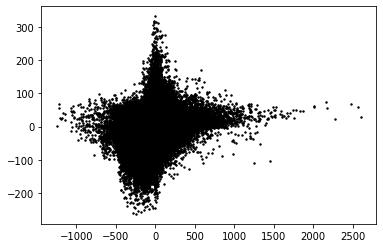

In [42]:
plt.scatter(Targets['dbe'][start:end+1].ravel(),Predictions['dbe'][start:end+1].ravel(),s=2.0,c='k')
# plt.scatter(Targets['dbe'].ravel(),prediction_weimer_dbe.ravel(),s=2.0,c='b')

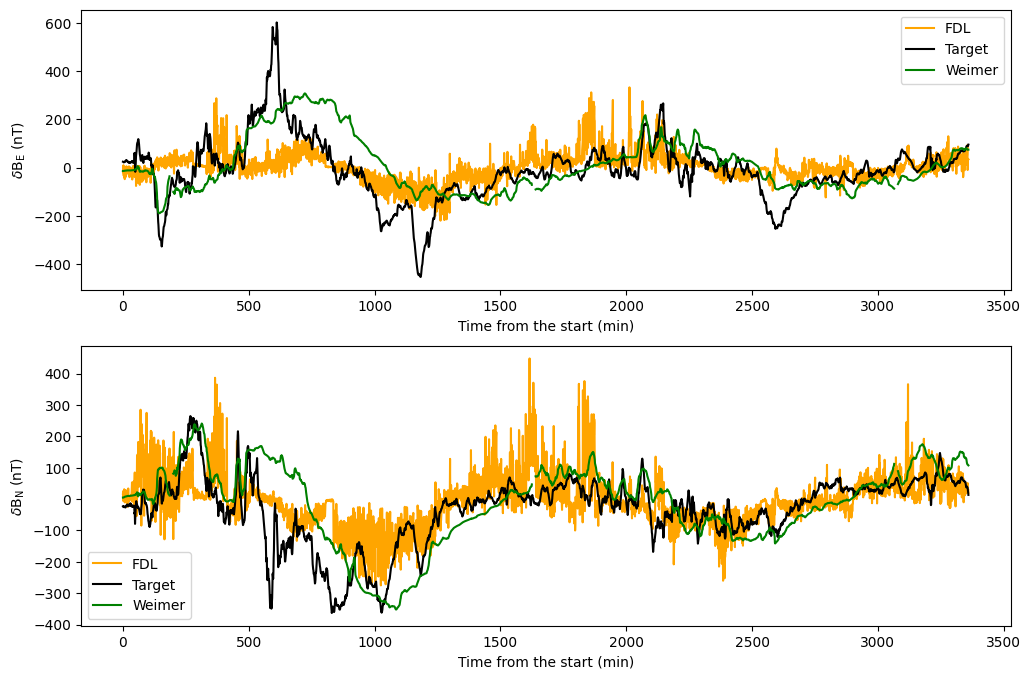

In [46]:
station_index = 100
plt.style.use('default')
fig,ax = plt.subplots(2,1,figsize=(12,8))

ax[0].plot(Predictions['dbe'][start:end+1][:,station_index],'orange',label='FDL')
ax[0].plot(Targets['dbe'][start:end+1][:,station_index],'k',label='Target')
ax[0].plot(prediction_weimer_dbe[:,station_index],'g',label='Weimer')
ax[0].set_ylabel("$\\delta \mathrm{B}_{\mathrm{E}}$ (nT)")
ax[0].set_xlabel("Time from the start (min)")
ax[0].legend(loc='best')

ax[1].plot(Predictions['dbn'][start:end+1][:,station_index],'orange',label='FDL')
ax[1].plot(Targets['dbn'][start:end+1][:,station_index],'k',label='Target')
ax[1].plot(prediction_weimer_dbn[:,station_index],'g',label='Weimer')
ax[1].set_ylabel("$\\delta \mathrm{B}_{\mathrm{N}}$ (nT)")
ax[1].set_xlabel("Time from the start (min)")
ax[1].legend(loc='best')

------------------------

## 2011 storm

### Load the Weimer forecasts

In [47]:
weimer = {}
with h5py.File(f"../data_local/weimer/2011/TimeStepGeomagnetic_20110805_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

In [48]:
dataset = np.load("../Subset/Weimer/2011/supermag_omni_data.npz")
supermag_data = SuperMAGIAGADataset(dataset['dates'],dataset['data'],dataset['features'])
omni_data = OMNIDataset(pd.DataFrame(data=dataset['omni'],columns=dataset['omni_features']))
storm_idx = dataset['idx']

In [49]:
storm_dataset = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,storm_idx,
        f107_dataset="../Subset/Weimer/2011/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=scalers,training_batch=False,nmax=nmax,inference=True)
storm_loader = data.DataLoader(storm_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

extracting f107
using existing scaler


### FDL Forecast

In [50]:
Predictions,Targets,All_times_coeff,Date_arr,MLT_sup_all,Mcolat_sup_all = Forecaster(storm_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std,target_index)

### Weimer forecasts on supermag

In [51]:
start = np.argmin(np.abs(Date_arr['dbe']-weimer_times_unix[0]))
end = np.argmin(np.abs(Date_arr['dbe']-weimer_times_unix[-1]))

In [52]:
weimer['DB'][:,1].shape,MLT_sup_all['dbe'].shape,Mcolat_sup_all['dbe'].shape, Predictions['dbe'].shape

((2581, 100, 96), (2581, 175), (2581, 175), (2581, 175))

### Get the Weimer basis

In [53]:
print(weimer.keys())
weimer_mlt = np.deg2rad(90-weimer['GRIDMLTS']*360/24.0)
weimer_colat = np.deg2rad(90 - weimer['GRIDLATS'])
weimer_basis = basis_matrix(nmax ,weimer_mlt, weimer_colat)
weimer_shape = weimer['GRIDMLTS'].shape


dict_keys(['DB', 'GRIDLATS', 'GRIDMLTS', 'JDTIMES', 'LATITUDES', 'MLTVALS'])


In [54]:
prediction_weimer_dbn = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,0],
                                                          MLT_sup_all['dbn'][start:end+1],Mcolat_sup_all['dbn'][start:end+1])
prediction_weimer_dbe = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,1],
                                                          MLT_sup_all['dbe'][start:end+1],Mcolat_sup_all['dbe'][start:end+1])

### Generate metrics

In [55]:
Targets['dbe'].shape,Predictions['dbe'].shape

((2581, 175), (2581, 175))

In [56]:
fdl_metrics_dbe = Generate_metrics(Targets['dbe'][start:end+1],Predictions['dbe'][start:end+1])
fdl_metrics_dbn = Generate_metrics(Targets['dbn'][start:end+1],Predictions['dbn'][start:end+1])

weimer_metrics_dbe = Generate_metrics(Targets['dbe'][start:end+1],prediction_weimer_dbn)
weimer_metrics_dbn = Generate_metrics(Targets['dbn'][start:end+1],prediction_weimer_dbe)

In [57]:
print(f"FDL dbe:{fdl_metrics_dbe}")
print(f"Weimer dbe:{weimer_metrics_dbe}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn}")
print(f"Weimer dbn: {weimer_metrics_dbn}")

FDL dbe:{'mse': 72.68753832514639, 'mae': 34.92979212547881, 'r2': -0.0005408263459218354}
Weimer dbe:{'mse': 127.54813462536887, 'mae': 67.40957899675112, 'r2': -3.920962221623218}
--------------------
FDL dbn: {'mse': 100.0674599387611, 'mae': 53.16926925494961, 'r2': -0.010422923392230832}
Weimer dbn: {'mse': 140.93849483996638, 'mae': 76.74773204486179, 'r2': -0.8571321181684023}


In [58]:
eventmets_fdl = EventMetrics(Targets['dbe'][start:end+1],Targets['dbn'][start:end+1],Predictions['dbe'][start:end+1],Predictions['dbn'][start:end+1])
eventmets_weimer = EventMetrics(Targets['dbe'][start:end+1],Targets['dbn'][start:end+1],prediction_weimer_dbe,prediction_weimer_dbn)

(20, 1)
(20, 1)
(20, 1)
(20, 1)


/home/uvishal/data/geoeffectivenet/Benchmark/metricgen.py:58: RuntimeWarning: invalid value encountered in true_divide
  pod = tmpconf['hits']/(tmpconf['hits']+tmpconf['misses'])
/home/uvishal/data/geoeffectivenet/Benchmark/metricgen.py:61: RuntimeWarning: invalid value encountered in true_divide
  hss = hss/((tmpconf['hits']+tmpconf['misses'])*(tmpconf['misses']+tmpconf['truenegative'])+(tmpconf['hits']+tmpconf['falsealarm'])*(tmpconf['falsealarm']+tmpconf['truenegative']))


In [59]:
for thresh in eventmets_fdl.keys():
  print(f"Threshold: {thresh}")
  for k in eventmets_fdl[thresh].keys():
    print(f"FDL {k}:{np.nanmean(eventmets_fdl[thresh][k])}+/-{np.nanstd(eventmets_fdl[thresh][k])}")
    print(f"Weimer {k}:{np.nanmean(eventmets_weimer[thresh][k])}+/-{np.nanstd(eventmets_weimer[thresh][k])}")
    print("------------")
  print("******************************************")

Threshold: 0.3
FDL pod:0.6416136675918365+/-0.2763203507483797
Weimer pod:0.1716780876857647+/-0.13722826869613022
------------
FDL pofd:0.12871695191202862+/-0.09431179937902608
Weimer pofd:0.013867721127772376+/-0.0190863644965112
------------
FDL hss:0.38429217494173973+/-0.2364174846089899
Weimer hss:0.18231994108033162+/-0.15016262006997239
------------
******************************************
Threshold: 0.7
FDL pod:0.5846790239148048+/-0.27985569414976585
Weimer pod:0.08928622263216189+/-0.09374863862228291
------------
FDL pofd:0.07110771804693643+/-0.08321854669811542
Weimer pofd:0.0037679295749592696+/-0.006993506994878661
------------
FDL hss:0.3245748288857464+/-0.2213700468434665
Weimer hss:0.1188583390165692+/-0.1328548444327982
------------
******************************************
Threshold: 1.1
FDL pod:0.4417444008000219+/-0.3441929596135884
Weimer pod:0.04520186711588096+/-0.09839392389575487
------------
FDL pofd:0.04314489834816734+/-0.05607880860457431
Weimer pof

## Check plots

In [60]:
Targets['dbe'].shape,Predictions['dbe'].shape,prediction_weimer_dbn.shape

((2581, 175), (2581, 175), (2581, 175))

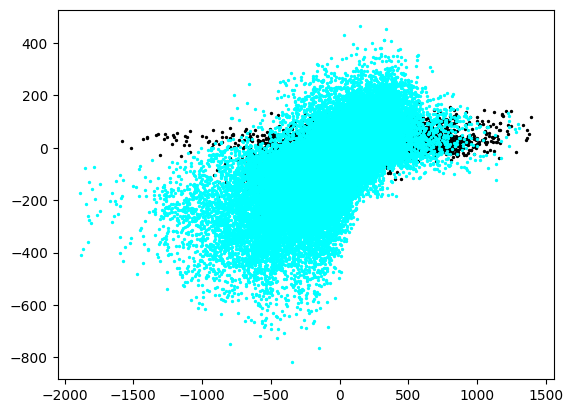

In [63]:
plt.scatter(Targets['dbe'][start:end+1].ravel(),Predictions['dbe'][start:end+1].ravel(),s=2.0,c='k')
plt.scatter(Targets['dbn'][start:end+1].ravel(),Predictions['dbn'][start:end+1].ravel(),s=2.0,c='cyan')

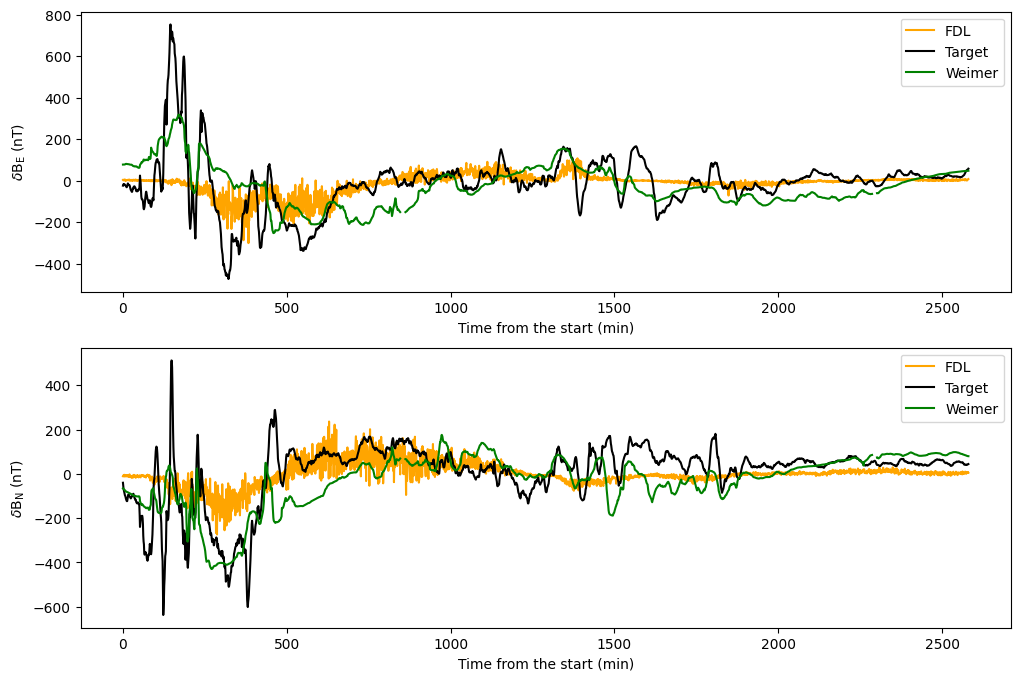

In [62]:
station_index = 100
plt.style.use('default')
fig,ax = plt.subplots(2,1,figsize=(12,8))

ax[0].plot(Predictions['dbe'][start:end+1][:,station_index],'orange',label='FDL')
ax[0].plot(Targets['dbe'][start:end+1][:,station_index],'k',label='Target')
ax[0].plot(prediction_weimer_dbe[:,station_index],'g',label='Weimer')
ax[0].set_ylabel("$\\delta \mathrm{B}_{\mathrm{E}}$ (nT)")
ax[0].set_xlabel("Time from the start (min)")
ax[0].legend(loc='best')

ax[1].plot(Predictions['dbn'][start:end+1][:,station_index],'orange',label='FDL')
ax[1].plot(Targets['dbn'][start:end+1][:,station_index],'k',label='Target')
ax[1].plot(prediction_weimer_dbn[:,station_index],'g',label='Weimer')
ax[1].set_ylabel("$\\delta \mathrm{B}_{\mathrm{N}}$ (nT)")
ax[1].set_xlabel("Time from the start (min)")
ax[1].legend(loc='best')

In [ ]:
All_times_coeff['dbn'].shape